In [45]:
# Setup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway, pearsonr
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Load the player_per_game and player_award_shares datasets
player_per_game = pd.read_csv('Player_per_game.csv')
player_award_shares = pd.read_csv('Player_award_shares.csv')

# Filter out all entries from before the year 2000
player_per_game = player_per_game[player_per_game['season'] >= 2000]
player_award_shares = player_award_shares[player_award_shares['season'] >= 2000]

# Remove duplicated information for some players who were traded mid-season
multi_team_players = player_per_game[player_per_game.duplicated(subset=['player', 'season'], keep=False)]['player'].unique()
player_per_game = player_per_game[(player_per_game['tm'] == 'TOT') | (~player_per_game['player'].isin(multi_team_players))]
player_per_game = player_per_game.reset_index(drop=True)

# Remove these columns since they are irrelevant (The ABA does not exist in the timespan we are looking at and already have age).
player_per_game = player_per_game.drop(columns=['birth_year', 'lg'])

# Edit the position field to only include the player's primary position
player_per_game['pos'] = player_per_game['pos'].str.split('-').str[0]

# Create a new field total_contributions_per_game, that combines points, rebounds, and assists.
player_per_game['total_contributions_per_game'] = (player_per_game['pts_per_game'] + player_per_game['trb_per_game'] + player_per_game['ast_per_game'])

# All of the awards we want data for
awards = ['dpoy', 'mip', 'nba mvp']

# Creating separate columns for each of the awards
award_columns = []
for award in awards:
  award_columns.append(f'{award.lower().replace(" ", "_")}_share')
  award_columns.append(f'{award.lower().replace(" ", "_")}_winner')

# Pivoting the table to add columns for each award and consolidate each player's information
award_pivot = player_award_shares.pivot_table(
    index=['player_id', 'seas_id', 'season', 'player', 'age', 'tm'],
    columns='award',
    values=['share', 'winner'],
    aggfunc={'share' : 'sum', 'winner' : 'any'},
    fill_value=0
)

award_pivot.columns = [f'{col[1].lower().replace(" ", "_")}_{col[0]}' for col in award_pivot.columns]
award_pivot = award_pivot.reset_index()

for award in awards:
    winner_col = f'{award.lower().replace(" ", "_")}_winner'
    award_pivot[winner_col] = award_pivot[winner_col].astype(bool)

# Merging the per game statistics and the award data
final_merged_data = pd.merge(player_per_game, award_pivot, on=['player_id', 'seas_id'], how='left')

# Filling in NaNs with appropriate values
award_share_columns = [f'{award.lower().replace(" ", "_")}_share' for award in awards]
final_merged_data[award_share_columns] = final_merged_data[award_share_columns].fillna(0)

winner_columns = [f'{award.lower().replace(" ", "_")}_winner' for award in awards]
final_merged_data[winner_columns] = final_merged_data[winner_columns].fillna(False)

final_merged_data = final_merged_data.drop(columns=['season_y', 'player_y', 'age_y', 'tm_y', 'clutch_poy_share', 'nba_roy_share', 'smoy_share', 'clutch_poy_winner', 'nba_roy_winner', 'smoy_winner'])

print(final_merged_data.head())


   seas_id  season_x  player_id       player_x pos  age_x  experience tm_x  \
0    31136      2024       5025     A.J. Green  SG   24.0           2  MIL   
1    31138      2024       5027     AJ Griffin  SF   20.0           2  ATL   
2    31141      2024       4805  Aaron Nesmith  SF   24.0           4  IND   
3    31142      2024       4900  Aaron Wiggins  SG   25.0           3  OKC   
4    31143      2024       5109   Adam Flagler  SG   24.0           1  OKC   

    g    gs  ...  tov_per_game  pf_per_game  pts_per_game  \
0  56   0.0  ...           0.2          0.9           4.5   
1  20   0.0  ...           0.4          0.3           2.4   
2  72  47.0  ...           0.9          3.3          12.2   
3  78   4.0  ...           0.7          1.2           6.9   
4   2   0.0  ...           0.0          0.0           1.5   

   total_contributions_per_game  dpoy_share  mip_share  nba_mvp_share  \
0                           6.1         0.0      0.000            0.0   
1                 

<ipython-input-45-dedbf692a8f1>:69: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_merged_data[winner_columns] = final_merged_data[winner_columns].fillna(False)


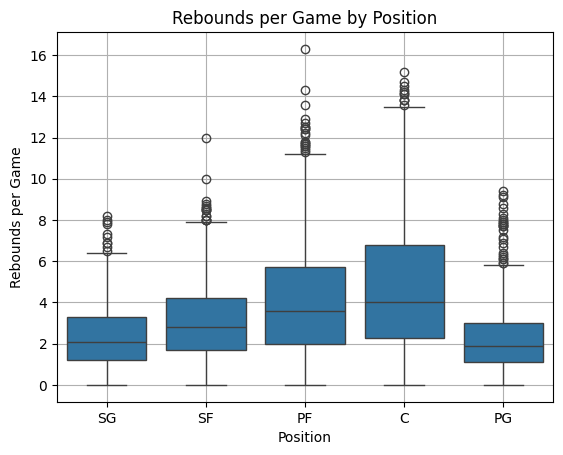

F-statistic: 343.038917468365, p-value: 3.004124436143729e-268
There is a significant difference in rebounds per game between positions.


In [27]:
# Experiment 1: Effect of Position on Rebounds per Game

plt.figure()
sns.boxplot(data=final_merged_data, x='pos', y='trb_per_game')
plt.title("Rebounds per Game by Position")
plt.xlabel("Position")
plt.ylabel("Rebounds per Game")
plt.grid(True)
plt.show()

grouped_data = [group['trb_per_game'].values for name, group in final_merged_data.groupby('pos')]

f_stat, p_value = f_oneway(*grouped_data)

print(f"F-statistic: {f_stat}, p-value: {p_value}")
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference in rebounds per game between positions.")
else:
    print("There is no significant difference in rebounds per game between positions.")

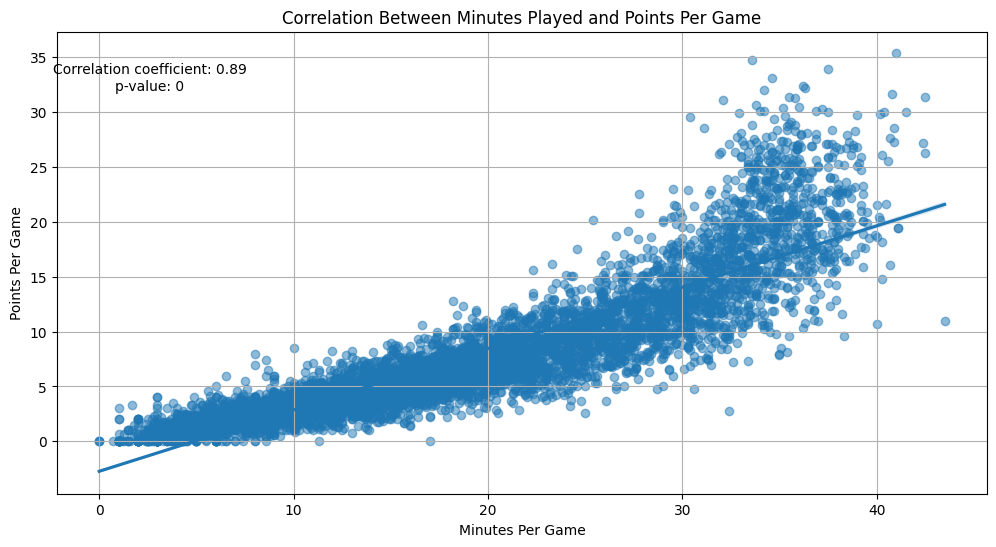

Reject the null hypothesis: significant correlation between minutes played and points scored.


In [28]:
# Experiment 2: Correlation between Minutes Played and ppg

corr, p_value = pearsonr(final_merged_data['mp_per_game'], final_merged_data['pts_per_game'])

plt.figure(figsize=(12, 6))
sns.regplot(x='mp_per_game', y='pts_per_game', data=final_merged_data, scatter_kws={'alpha':0.5})
plt.title('Correlation Between Minutes Played and Points Per Game')
plt.xlabel('Minutes Per Game')
plt.ylabel('Points Per Game')
plt.grid(True)
plt.text(0.1, 0.9, f'Correlation coefficient: {corr:.2f}\np-value: {p_value:.2g}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: significant correlation between minutes played and points scored.")
else:
    print("Fail to reject the null hypothesis: no significant correlation.")

<ipython-input-29-f6c8b18ca173>:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(0.1, 0.9, f'R²: {model.rsquared:.2f}\np-value: {model.pvalues[1]:.2g}',


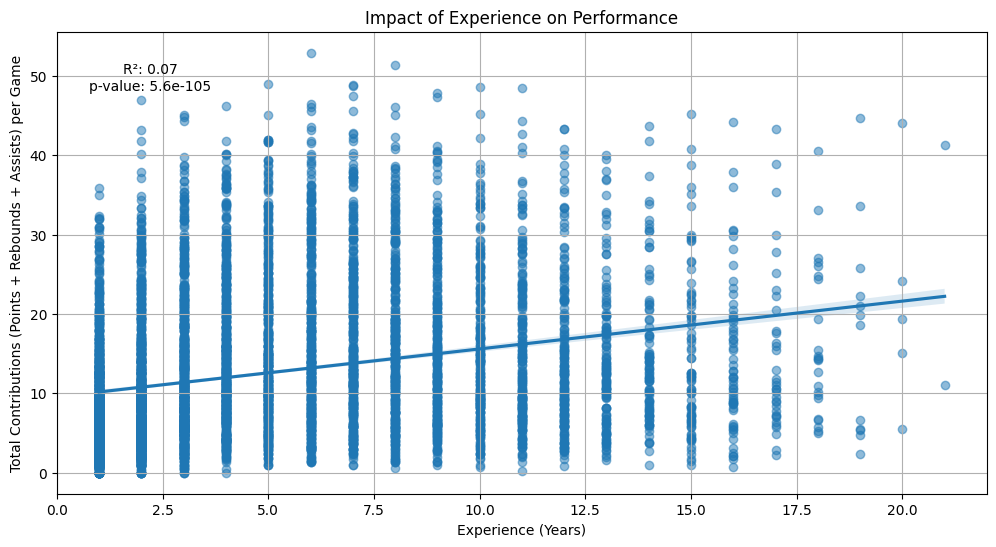

                                 OLS Regression Results                                 
Dep. Variable:     total_contributions_per_game   R-squared:                       0.070
Model:                                      OLS   Adj. R-squared:                  0.070
Method:                           Least Squares   F-statistic:                     491.2
Date:                          Tue, 03 Dec 2024   Prob (F-statistic):          5.65e-105
Time:                                  21:26:26   Log-Likelihood:                -23465.
No. Observations:                          6489   AIC:                         4.693e+04
Df Residuals:                              6487   BIC:                         4.695e+04
Df Model:                                     1                                         
Covariance Type:                      nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

In [29]:
# Experiment 3: Impact of experience on performance

X = final_merged_data['experience']
y = final_merged_data['total_contributions_per_game']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()

plt.figure(figsize=(12, 6))
sns.regplot(x='experience', y='total_contributions_per_game', data=final_merged_data, scatter_kws={'alpha':0.5})
plt.title('Impact of Experience on Performance')
plt.xlabel('Experience (Years)')
plt.ylabel('Total Contributions (Points + Rebounds + Assists) per Game')
plt.grid(True)
plt.text(0.1, 0.9, f'R²: {model.rsquared:.2f}\np-value: {model.pvalues[1]:.2g}',
         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
plt.show()

# Print the summary of the regression
print(model.summary())

<ipython-input-46-9a4eaa030bb5>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_merged_data['mvp_share'] = final_merged_data['nba_mvp_share'].fillna(0)
<ipython-input-46-9a4eaa030bb5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_merged_data['dpoy_share'] = final_merged_data['dpoy_share'].fillna(0)
<ipython-input-46-9a4eaa030bb5>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

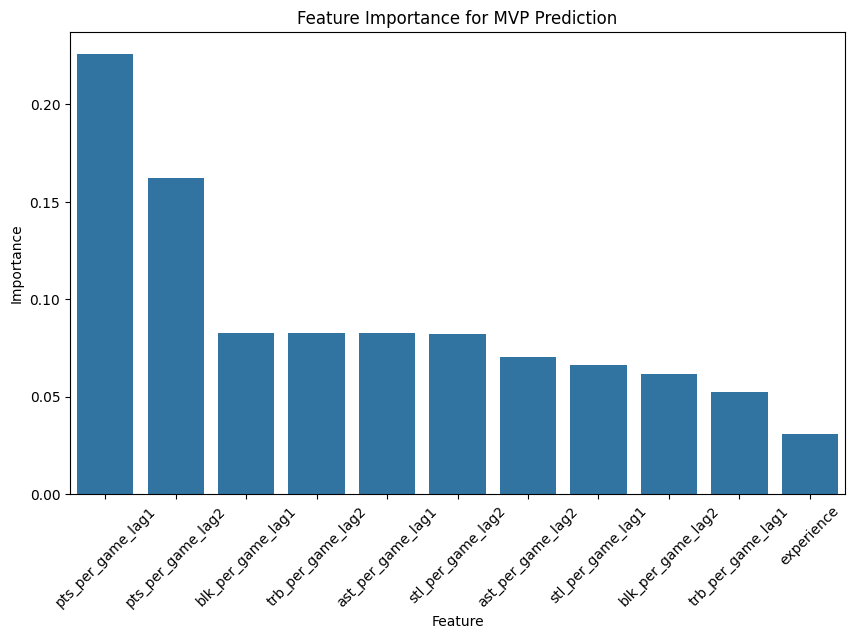

Top 10 Predicted MVPs for 2025 (Share):
                      player  predicted_mvp_share  predicted_dpoy_share  \
189             Nikola Jokić              0.52208               0.32302   
82     Giannis Antetokounmpo              0.34856               0.03826   
119              Joel Embiid              0.30455               0.03767   
215  Shai Gilgeous-Alexander              0.28352               0.00264   
155             LeBron James              0.27805               0.00334   
161              Luka Dončić              0.13544               0.00452   
47            Darius Garland              0.11609               0.00022   
199              Paul George              0.09360               0.01743   
217            Stephen Curry              0.07077               0.00165   
227               Trae Young              0.06782               0.00032   

     predicted_mip_share  
189              0.00018  
82               0.00000  
119              0.00216  
215              0.10060  

In [46]:
# Step 1: Ensure the dataset is sorted by player and season
final_merged_data = final_merged_data.sort_values(by=['player_x', 'season_x'])

# Step 2: Create lag features for the previous two seasons
for lag in [1, 2]:
    for stat in ['pts_per_game', 'ast_per_game', 'trb_per_game', 'stl_per_game', 'blk_per_game']:
        final_merged_data[f'{stat}_lag{lag}'] = final_merged_data.groupby('player_x')[stat].shift(lag)

# Drop rows where lag values are NaN (early seasons where lag data doesn't exist, rookies)
final_merged_data = final_merged_data.dropna(subset=['pts_per_game_lag1', 'pts_per_game_lag2'])

# Step 3: Create binary labels for each award based on whether the player won that season
final_merged_data['mvp_share'] = final_merged_data['nba_mvp_share'].fillna(0)
final_merged_data['dpoy_share'] = final_merged_data['dpoy_share'].fillna(0)
final_merged_data['mip_share'] = final_merged_data['mip_share'].fillna(0)

# Step 4: Define features and labels
features = [
    'pts_per_game_lag1', 'ast_per_game_lag1', 'trb_per_game_lag1', 'stl_per_game_lag1', 'blk_per_game_lag1',
    'pts_per_game_lag2', 'ast_per_game_lag2', 'trb_per_game_lag2', 'stl_per_game_lag2', 'blk_per_game_lag2', 'experience'
]

X = final_merged_data[features]
y_mvp = final_merged_data['mvp_share']
y_dpoy = final_merged_data['dpoy_share']
y_mip = final_merged_data['mip_share']

# Step 5: Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_mvp, y_test_mvp = train_test_split(X, y_mvp, test_size=0.2, random_state=42)
X_train, X_test, y_train_dpoy, y_test_dpoy = train_test_split(X, y_dpoy, test_size=0.2, random_state=42)
X_train, X_test, y_train_mip, y_test_mip = train_test_split(X, y_mip, test_size=0.2, random_state=42)

# Step 6: Initialize the Random Forest Regressor
rf_mvp = RandomForestRegressor(n_estimators=100, random_state=42)
rf_dpoy = RandomForestRegressor(n_estimators=100, random_state=42)
rf_mip = RandomForestRegressor(n_estimators=100, random_state=42)

# Step 7: Fit the models
rf_mvp.fit(X_train, y_train_mvp)
rf_dpoy.fit(X_train, y_train_dpoy)
rf_mip.fit(X_train, y_train_mip)

# Step 8: Make predictions on the test data
y_pred_mvp = rf_mvp.predict(X_test)
y_pred_dpoy = rf_dpoy.predict(X_test)
y_pred_mip = rf_mip.predict(X_test)

# Step 9: Feature importance visualization for MVP prediction (you can adjust this for other awards)
def plot_feature_importance(rf_model, features, title):
    feature_importances = rf_model.feature_importances_
    features_sorted = sorted(zip(features, feature_importances), key=lambda x: x[1], reverse=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=[x[0] for x in features_sorted], y=[x[1] for x in features_sorted])
    plt.title(title)
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.xticks(rotation=45)
    plt.show()

# Plot feature importance for MVP
plot_feature_importance(rf_mvp, features, "Feature Importance for MVP Prediction")

# Step 10: Aggregate the player stats for 2023 and 2024
recent_season_data = final_merged_data[final_merged_data['season_x'].isin([2023, 2024])]
test_data_aggregated = recent_season_data.groupby('player_x').agg({
    'pts_per_game_lag1': 'mean',
    'ast_per_game_lag1': 'mean',
    'trb_per_game_lag1': 'mean',
    'stl_per_game_lag1': 'mean',
    'blk_per_game_lag1': 'mean',
    'pts_per_game_lag2': 'mean',
    'ast_per_game_lag2': 'mean',
    'trb_per_game_lag2': 'mean',
    'stl_per_game_lag2': 'mean',
    'blk_per_game_lag2': 'mean',
    'nba_mvp_share': 'mean',
    'dpoy_share': 'mean',
    'mip_share': 'mean',
    'experience': 'mean'
}).reset_index()

# Step 11: Define features and labels again for the aggregated 2023-2024 data
X_test_aggregated = test_data_aggregated[features]
y_test_mvp = test_data_aggregated['nba_mvp_share']
y_test_dpoy = test_data_aggregated['dpoy_share']
y_test_mip = test_data_aggregated['mip_share']

# Step 12: Make predictions on the aggregated 2023-2024 test set
y_pred_mvp_2025 = rf_mvp.predict(X_test_aggregated)
y_pred_dpoy_2025 = rf_dpoy.predict(X_test_aggregated)
y_pred_mip_2025 = rf_mip.predict(X_test_aggregated)

# Step 13: Create a DataFrame to store the predictions
predictions_2025 = pd.DataFrame({
    'player': test_data_aggregated['player_x'],
    'predicted_mvp_share': y_pred_mvp_2025,
    'predicted_dpoy_share': y_pred_dpoy_2025,
    'predicted_mip_share': y_pred_mip_2025
})

# Step 14: Rank players based on predicted award share
predictions_2025_mvp = predictions_2025.sort_values(by='predicted_mvp_share', ascending=False)
predictions_2025_dpoy = predictions_2025.sort_values(by='predicted_dpoy_share', ascending=False)
predictions_2025_mip = predictions_2025.sort_values(by='predicted_mip_share', ascending=False)

# Display top 10 predicted players for each award
print("Top 10 Predicted MVPs for 2025 (Share):")
print(predictions_2025_mvp.head(10))

print("\nTop 10 Predicted DPOYs for 2025 (Share):")
print(predictions_2025_dpoy.head(10))

print("\nTop 10 Predicted MIPs for 2025 (Share):")
print(predictions_2025_mip.head(10))
